In [1]:
# Python implementation (visible) for PlayTennis Decision Tree — step-by-step numerical calculations + sklearn model & visualization
import pandas as pd
import numpy as np
from math import log2
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# 1) Create the PlayTennis dataset (as in the provided image)
data = {
    'Outlook': ['Sunny','Sunny','Overcast','Rainy','Rainy','Rainy','Overcast','Sunny','Sunny','Rainy','Sunny','Overcast','Overcast','Rainy'],
    'Temperature': ['Hot','Hot','Hot','Mild','Cool','Cool','Cool','Mild','Cool','Mild','Mild','Mild','Hot','Mild'],    
    'PlayTennis': ['No','No','Yes','Yes','Yes','No','Yes','No','Yes','Yes','Yes','Yes','Yes','No']
}

df = pd.DataFrame(data)
df_indexed = df.copy()
df_indexed.index = range(1, len(df)+1)


In [2]:
# Display the dataset in your notebook
print("PlayTennis Dataset:")
display(df_indexed)   # works in Jupyter/Colab


PlayTennis Dataset:


,Outlook,Temperature,PlayTennis
1,Sunny,Hot,No
2,Sunny,Hot,No
3,Overcast,Hot,Yes
4,Rainy,Mild,Yes
5,Rainy,Cool,Yes
6,Rainy,Cool,No
7,Overcast,Cool,Yes
8,Sunny,Mild,No
9,Sunny,Cool,Yes
10,Rainy,Mild,Yes


In [3]:
# --- Helper functions for manual calculation ---
def entropy_of_counts(counts):
    """Entropy given list or array of class counts."""
    total = sum(counts)
    if total == 0:
        return 0.0
    ent = 0.0
    for c in counts:
        if c == 0:
            continue
        p = c / total
        ent -= p * log2(p)
    return ent

def entropy_of_series(series):
    """Entropy of a pandas Series of categorical labels."""
    counts = series.value_counts().values
    print("counts:", counts)
    return entropy_of_counts(counts)

def info_gain(df, attribute, target='PlayTennis'):
    """Information gain of splitting df by categorical attribute."""
    parent_entropy = entropy_of_series(df[target])
    total = len(df)
    # compute weighted entropy after split
    weighted_ent = 0.0
    for val, subset in df.groupby(attribute):
        weighted_ent += (len(subset)/total) * entropy_of_series(subset[target])
    return parent_entropy - weighted_ent, parent_entropy, weighted_ent

In [4]:
entropy_of_counts([9, 5])  # Example usage

0.9402859586706311

In [5]:


# 2) Compute overall entropy
overall_entropy = entropy_of_series(df['PlayTennis'])
print(f"Overall Entropy (PlayTennis): {overall_entropy:.6f}\n")

counts: [9 5]
Overall Entropy (PlayTennis): 0.940286



In [6]:
# 3) Compute Information Gain for each attribute at root
attributes = ['Outlook','Temperature']
ig_results = {}
for attr in attributes:
    ig, parent_e, weighted_e = info_gain(df, attr)
    ig_results[attr] = (ig, parent_e, weighted_e)
    print(f"Attribute: {attr}")
    print(f"  Parent entropy: {parent_e:.6f}")
    print(f"  Weighted child entropy: {weighted_e:.6f}")
    print(f"  Information Gain: {ig:.6f}\n")


counts: [9 5]
counts: [4]
counts: [3 2]
counts: [3 2]
Attribute: Outlook
  Parent entropy: 0.940286
  Weighted child entropy: 0.693536
  Information Gain: 0.246750

counts: [9 5]
counts: [3 1]
counts: [2 2]
counts: [4 2]
Attribute: Temperature
  Parent entropy: 0.940286
  Weighted child entropy: 0.911063
  Information Gain: 0.029223



In [7]:

# Show which attribute is chosen at root
best_attr = max(ig_results, key=lambda k: ig_results[k][0])
print(f"Best attribute at root (max information gain): {best_attr} (IG = {ig_results[best_attr][0]:.6f})\n")

Best attribute at root (max information gain): Outlook (IG = 0.246750)



In [8]:
root = best_attr
for val, subset in df.groupby(root):
    print(f"--- Branch: {root} = {val} ---")
    print(f"Samples: {len(subset)}")
    print(subset[['Outlook','Temperature','PlayTennis']])

--- Branch: Outlook = Overcast ---
Samples: 4
     Outlook Temperature PlayTennis
2   Overcast         Hot        Yes
6   Overcast        Cool        Yes
11  Overcast        Mild        Yes
12  Overcast         Hot        Yes
--- Branch: Outlook = Rainy ---
Samples: 5
   Outlook Temperature PlayTennis
3    Rainy        Mild        Yes
4    Rainy        Cool        Yes
5    Rainy        Cool         No
9    Rainy        Mild        Yes
13   Rainy        Mild         No
--- Branch: Outlook = Sunny ---
Samples: 5
   Outlook Temperature PlayTennis
0    Sunny         Hot         No
1    Sunny         Hot         No
7    Sunny        Mild         No
8    Sunny        Cool        Yes
10   Sunny        Mild        Yes


In [9]:
# 4) For the chosen root (Outlook), compute details for each branch (Sunny, Overcast, Rainy)
root = best_attr
for val, subset in df.groupby(root):
    print(f"--- Branch: {root} = {val} ---")
    print(f"Samples: {len(subset)}")
    print(subset[['Outlook','Temperature','PlayTennis']])
    ent = entropy_of_series(subset['PlayTennis'])
    print(f"Entropy of this node: {ent:.6f}")
    # compute best attribute within this branch (excluding root)
    branch_attrs = [a for a in attributes if a != root]
    best_local = None
    best_ig_local = -1.0
    for a in branch_attrs:
        ig_loc, p_e_loc, w_e_loc = info_gain(subset, a)
        if ig_loc > best_ig_local:
            best_ig_local = ig_loc
            best_local = (a, ig_loc, p_e_loc, w_e_loc)
    print(f"Best attribute to split this branch: {best_local[0]} (IG = {best_local[1]:.6f})\n")

--- Branch: Outlook = Overcast ---
Samples: 4
     Outlook Temperature PlayTennis
2   Overcast         Hot        Yes
6   Overcast        Cool        Yes
11  Overcast        Mild        Yes
12  Overcast         Hot        Yes
counts: [4]
Entropy of this node: 0.000000
counts: [4]
counts: [1]
counts: [2]
counts: [1]
Best attribute to split this branch: Temperature (IG = 0.000000)

--- Branch: Outlook = Rainy ---
Samples: 5
   Outlook Temperature PlayTennis
3    Rainy        Mild        Yes
4    Rainy        Cool        Yes
5    Rainy        Cool         No
9    Rainy        Mild        Yes
13   Rainy        Mild         No
counts: [3 2]
Entropy of this node: 0.970951
counts: [3 2]
counts: [1 1]
counts: [2 1]
Best attribute to split this branch: Temperature (IG = 0.019973)

--- Branch: Outlook = Sunny ---
Samples: 5
   Outlook Temperature PlayTennis
0    Sunny         Hot         No
1    Sunny         Hot         No
7    Sunny        Mild         No
8    Sunny        Cool        Yes
10  

Label encodings:
 Outlook: {'Overcast': np.int64(0), 'Rainy': np.int64(1), 'Sunny': np.int64(2)}
 Temperature: {'Cool': np.int64(0), 'Hot': np.int64(1), 'Mild': np.int64(2)}
 PlayTennis: {'No': np.int64(0), 'Yes': np.int64(1)}

Decision tree rules (export_text):

|--- Outlook <= 0.50
|   |--- class: 1
|--- Outlook >  0.50
|   |--- Temperature <= 0.50
|   |   |--- Outlook <= 1.50
|   |   |   |--- class: 0
|   |   |--- Outlook >  1.50
|   |   |   |--- class: 1
|   |--- Temperature >  0.50
|   |   |--- Temperature <= 1.50
|   |   |   |--- class: 0
|   |   |--- Temperature >  1.50
|   |   |   |--- Outlook <= 1.50
|   |   |   |   |--- class: 1
|   |   |   |--- Outlook >  1.50
|   |   |   |   |--- class: 0

Feature importances:
 Outlook: 0.627038
 Temperature: 0.372962



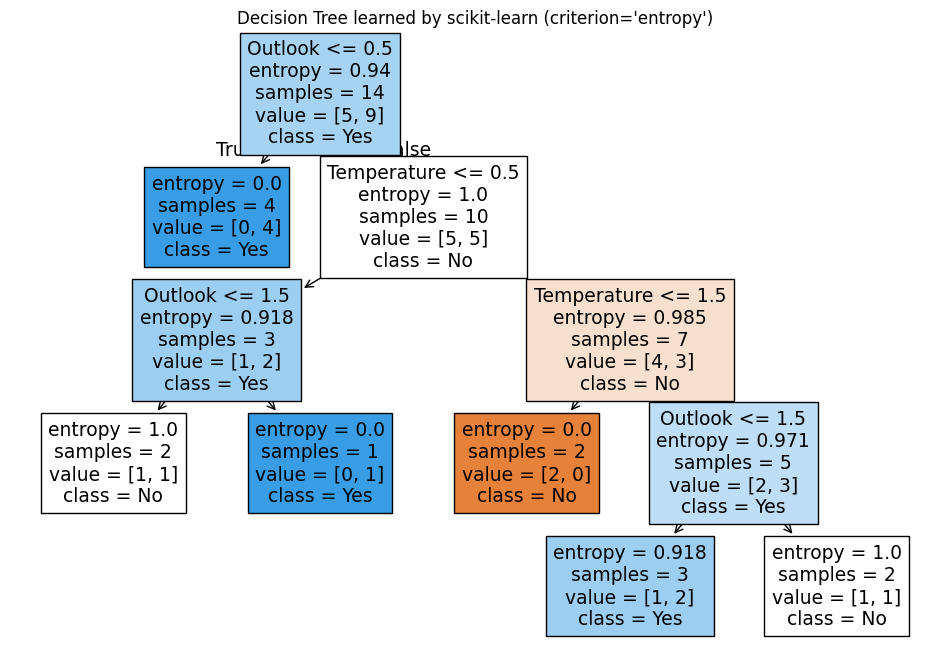

Example predictions:


,Outlook,Temperature,Prediction
0,Sunny,Hot,No
1,Sunny,Cool,Yes
2,Rainy,Mild,Yes
3,Overcast,Hot,Yes


In [10]:

# 5) Build scikit-learn Decision Tree (use LabelEncoder to encode categorical features to numeric)
encoders = {}
X = df.drop(columns=['PlayTennis']).copy()
y = df['PlayTennis'].copy()

# Encode categorical columns (Outlook, Temperature) with LabelEncoder
for col in ['Outlook','Temperature']:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    encoders[col] = le

# Encode target
le_target = LabelEncoder()
y_enc = le_target.fit_transform(y)  # Yes/No -> numeric

print("Label encodings:")
for col, le in encoders.items():
    print(f" {col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")
print(f" PlayTennis: {dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))}\n")

# Train classifier with entropy (to match manual IG calculations)
clf = DecisionTreeClassifier(criterion='entropy', random_state=0)
clf.fit(X, y_enc)

# Print textual rules (export_text)
tree_rules = export_text(clf, feature_names=list(X.columns))
print("Decision tree rules (export_text):\n")
print(tree_rules)

# Feature importances
fi = dict(zip(X.columns, clf.feature_importances_))
print("Feature importances:")
for k, v in fi.items():
    print(f" {k}: {v:.6f}")
print("")

# Plot the tree
plt.figure(figsize=(12,8))
plot_tree(clf, feature_names=list(X.columns), class_names=le_target.classes_, filled=True)
plt.title("Decision Tree learned by scikit-learn (criterion='entropy')")
plt.show()

# 6) Predictions examples
sample_examples = pd.DataFrame([
    {'Outlook':'Sunny','Temperature':'Hot'},
    {'Outlook':'Sunny','Temperature':'Cool'},
    {'Outlook':'Rainy','Temperature':'Mild'},
    {'Outlook':'Overcast','Temperature':'Hot'}
])
# encode examples using the same encoders
for col in ['Outlook','Temperature']:
    sample_examples[col] = encoders[col].transform(sample_examples[col])

preds = clf.predict(sample_examples)
preds_label = le_target.inverse_transform(preds)
sample_examples_display = sample_examples.copy()
# decode encoded categorical columns for display
for col in ['Outlook','Temperature']:
    sample_examples_display[col] = encoders[col].inverse_transform(sample_examples_display[col])
sample_examples_display['Prediction'] = preds_label
# Display the dataset in your notebook
print("Example predictions:")
display(sample_examples_display)   # works in Jupyter/Colab
